## Brand Value and Customer's Reflection 

Goal: By comparing user comments to keywords, we will evaluate the alignment of the brand's mission statements (how they intend to potray themselves) to user's perception of their brands. We aim to quantify how much consumers reflect the brand's values. 

The alignment is calculated using Sentence Transformer alignment score and cosine similarity



In [18]:

import gc
gc.collect()
import pandas as pd
import numpy as np
# import spacy
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob 
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import cos_sim

import torch
import webbrowser
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import gensim
from gensim.models import LdaModel  
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel 

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from keybert import KeyBERT
kw_model = KeyBERT(model='all-MiniLM-L6-v2')  


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/floodywaves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
data_path = '../../../data/'
output_path = "../../../output/alignment_analysis/"


In [58]:
#Loading the data
brand_value = pd.read_csv(data_path + "/brand_values.csv")
user_comment = pd.read_csv(data_path + "/alignment_analysis/subreddit_comment_data.csv")
print(user_comment.shape)
brand_value.columns = brand_value.columns.str.strip().str.lower()
user_comment.columns = user_comment.columns.str.strip().str.lower()

user_comment = user_comment[user_comment["brand"].notna()]

user_comment["brand"].unique()

brand_mapping = {
    'fenty': 'Fenty Beauty',
    'Fenty': 'Fenty Beauty',
    'etude': 'Etude House',
    'e.l.f.': 'e.l.f. Cosmetics',
    'Etude': 'Etude House',
    'elf': 'e.l.f. Cosmetics', 
    'Tarte': 'Tarte Cosmetics'
}
user_comment = user_comment.dropna(subset=["brand"])
user_comment["brand"] = user_comment["brand"].replace(brand_mapping) 

def normalize_brand(name):
    return brand_mapping.get(name.lower().strip(), name.strip())

user_comment["normalized_brand"] = user_comment["brand"].apply(normalize_brand)

user_comment["brand"].unique()

(1304, 6)


array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [59]:
brand_value = brand_value.rename(columns={"brand": "search_term", "values/ mission": "brand_mission"})

new_df = user_comment.merge(
    brand_value[["search_term", "brand_mission"]],
    left_on="brand",
    right_on="search_term",
    how="inner"
)

new_df.head()

,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?,return give someone,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to see if it’s tolerated there otherwise I would give it to a friend or family,chest area see tolerated otherwise would give friend family,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."
2,psd79w,[Product Question] Estée Lauder Advanced Night Repair Serum - how much to use per session??,Estée Lauder,SkincareAddiction,"I've used this serum for years and it's one of my favourites. I use a couple of drops which covers my face, neck and scalp (I'm bald guy). \n\nI find it's better straight after a toner so your skin is damp (or just wet your face first.)\n\nI've never used full dropper it's simply unnecessary.",used serum years one favourites couple drops covers neck scalp bald guy find better straight toner damp wet first never used full dropper simply unnecessary,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."
3,psd79w,[Product Question] Estée Lauder Advanced Night Repair Serum - how much to use per session??,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and the sooner you’ll have to replace it, so of course the company would like you to use as much as possible per application. A few drops of most any serum should be plenty, as long as you’re thinly but evenly covering all the areas you’re applying it to.",faster sooner replace course company would much possible per application drops serum plenty long thinly evenly covering areas applying,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."
4,psd79w,[Product Question] Estée Lauder Advanced Night Repair Serum - how much to use per session??,Estée Lauder,SkincareAddiction,Hi am I the only one who feel like my serum bottle doesn't close properly? I tried to turn the cap to close it and then it will turn back slightly by itself. I'm afraid it will spill if I travel with it. 😥,one serum bottle close properly tried turn cap close turn slightly afraid spill travel,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."


In [60]:
print(new_df.columns) 
print(new_df.shape)

Index(['post_id', 'title', 'brand', 'subreddit_name', 'comment',
       'cleaned_comment', 'normalized_brand', 'search_term', 'brand_mission'],
      dtype='object')
(1304, 9)


In [61]:
# Compute alignment score
tqdm.pandas()
model = SentenceTransformer('all-MiniLM-L6-v2')

sample_df = new_df

# Encode the instagram comments as a vector 
# Meaning instrament comment matrix
text_embeds = model.encode(
    sample_df["cleaned_comment"].tolist(), 
    convert_to_tensor=True, 
    batch_size=64,     
    show_progress_bar=True
) 

brand_names = brand_value["search_term"].tolist()
brand_missions = brand_value["brand_mission"].tolist()

# Encode all brand mission statements at once
# Should out 10 vectors for each brand mission statement
brand_mission_embeds = model.encode(
    brand_missions,
    convert_to_tensor=True,
    batch_size=10,  
    show_progress_bar=False
)
# Create a dictionary to map brand names to their indices offor quick lookup on brand_mission_embeds
brand_index = {brand: i for i, brand in enumerate(brand_names)}
# Map to the numeric index
brand_indices_tensor = torch.tensor(
    sample_df["brand"].map(brand_index).tolist(), 
    device=text_embeds.device 
)

selected_brand_embeds = brand_mission_embeds[brand_indices_tensor] # grab the correct brand mission statement

# Vectorized cosine similarity between matching brand mission and instagram comments
similarities = cos_sim(text_embeds, selected_brand_embeds).diagonal()

sample_df["alignment_score"] = similarities.cpu().numpy().tolist()


Batches: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s]


In [62]:
pd.set_option("display.max_colwidth", None)
sample_df[sample_df["brand"] == "COSRX"].sort_values("alignment_score", ascending=False)


,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission,alignment_score
203,151t31w,[product question] COSRX Snail Mucin Essence,COSRX,SkincareAddiction,"If you're using this purely for moisture and glow, then their hyaluronic intensive serum in an identical bottle is much better. Same nice hydration but I don't get the small bumps and it doesn't pill under sunscreen.",using purely moisture hyaluronic intensive serum identical bottle much better nice hydration small bumps pill sunscreen,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.368507
222,lkgt3z,[Haul] I was pleasantly surprised when my COSRX haul from the company's website shipped out of CA instead of Korea and only took 3 days to arrive! Excited to try everything for the first time :),COSRX,SkincareAddiction,Balancium is my favorite nighttime moisturizer! I have been desperately missing it since I accidentally ordered their panthenol cream when I was trying to repurchase balancium. The new packaging is so similar.,balancium nighttime moisturizer desperately missing since accidentally ordered panthenol cream trying repurchase balancium packaging similar,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.344646
1106,1248bla,What are yall's thoughts on COSRX snail mucin?,COSRX,KoreanBeauty,The snail cream moisturizer is WAYYYYYYYYYYUYYYYYYYYYY better it helps so much with redness and makes me glowy but I don’t use it like a moisturizer I use it like a serum because it’s pretty lightweight and I have dry skin,snail cream moisturizer wayyyyyyyyyyuyyyyyyyyyy better helps much redness makes glowy moisturizer serum pretty lightweight dry,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.329818
219,13v5lto,[Product Question] Is COSRX any good?,COSRX,SkincareAddiction,"This is one of my favorite cleaners on the planet. I am 32, white, cisgender female, with combo/dry skin that is acne prone. Top 5 best cleaners I gave ever used.",one cleaners planet white cisgender female combo dry acne prone top cleaners gave ever used,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.329559
221,lkgt3z,[Haul] I was pleasantly surprised when my COSRX haul from

In [63]:
#Summary Data 
sample_df["z_score"] = sample_df.groupby("brand")["alignment_score"].transform(zscore)

insight = sample_df.groupby("brand").agg(
    mean_alignment = ("alignment_score", "mean"), 
    mean_z_alignment = ("z_score", "mean")).reset_index()

insight 

,brand,mean_alignment,mean_z_alignment
0,COSRX,0.141001,4.284013e-17
1,Estée Lauder,0.026660,-4.189521e-17
2,Etude House,0.066198,9.323879e-17
3,Fenty Beauty,0.156434,-9.009663e-17
4,Glossier,0.132091,-6.832142e-17
5,Innisfree,0.091795,-9.261157e-17
6,Laneige,0.193200,-4.481264e-17
7,Sulwhasoo,0.150761,-1.173214e-16
8,Tarte Cosmetics,0.063828,1.290957e-17
9,e.l.f. Cosmetics,0.134663,-1.494531e-16


In [64]:
#Classify the alignment score into top alignments and create a new dataframe

top_alignment_comment = sample_df.sort_values("alignment_score", ascending=False).drop_duplicates("brand")
top_alignment_comment["alignment_type"] = "Top Aligned"

low_alignment_comment = sample_df.sort_values("alignment_score", ascending=True).drop_duplicates("brand")
low_alignment_comment["alignment_type"] = "Lowest Aligned"

both_df = pd.concat([top_alignment_comment, low_alignment_comment]).sort_values(["brand", "alignment_type"])

both_df


,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission,alignment_score,z_score,alignment_type
1107,1248bla,What are yall's thoughts on COSRX snail mucin?,COSRX,KoreanBeauty,Did not work for me. Broke me out.,work broke,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",-0.076724,-2.162995,Lowest Aligned
203,151t31w,[product question] COSRX Snail Mucin Essence,COSRX,SkincareAddiction,"If you're using this purely for moisture and glow, then their hyaluronic intensive serum in an identical bottle is much better. Same nice hydration but I don't get the small bumps and it doesn't pill under sunscreen.",using purely moisture hyaluronic intensive serum identical bottle much better nice hydration small bumps pill sunscreen,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.368507,2.260162,Top Aligned
21,meb4ny,[Product Question] ordinary now owned by Estée Lauder,Estée Lauder,SkincareAddiction,I’m assuming this is why the 2% SA solution has been “reformulating” for like a year now haha.,assuming solution reformulating year haha,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",-0.126131,-2.431792,Lowest Aligned
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?,return give someone,Estée Lauder,Estée Lauder,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.175830,2.374147,Top Aligned
148,sb2o3d,[Skin Concern] tips on treating them? Got them after using Etude house collagen cream. Forhead was clear before using this cream.,Etude House,SkincareAddiction,"What’s your routine? Usually reactions from products will go away on their own eventually, but could be something else in your routine that’s contributing to them sticking around.",usually reactions away eventually could something else contributing sticking around,Etude House,Etude House,"The name ‘Etude’ means ‘beautiful study of Chopin’ in French. They are targeted to woman.\nSo their main color is pink. Because most of women like pink. The pink color is related to princess fantasy from women’s childhood. Also Etudehouse‘s brand slogan is “All of you are born as a princess!” They make the Princess Fantasy a reality. And they surpport their customer enjoy make up like playing and having fun rather than consider as repetitive boring routine. By various colors, satisfying quality, adorable design. To make all girls in this world sweet with fun items of Etude!\n\n",-0.093131,-1.886282,Lowest Aligned
846,1cebsu6,throwback: etude house,Etude House,As

In [53]:
pd.set_option("display.max_colwidth", None)
top_alignment_comment[["comment", "brand", "brand_mission", "alignment_score"]]

,comment,brand,brand_mission,alignment_score
3684,"As much as I love cosrx this is a whole scam . The peptides are not going to do anything for if you're above 30 and have mature skin. These are basic peptides to start of you're at your 20s.....this feels nice on the skin I'm a oily skin person and it felt really good on the skin but just like any other hydrating toners or moisturizer....why buy this instead of a moisturizer ? There's only one copper peptide which is the copper tripeptide . Very weak ingredients....with the price of it you can buy a copper peptide serum , a multipeptide or argline serum and a retinol.....which will work way better for your skin than this in the long term. The amount of peptides are stupidly low for the price .",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.659153
381,"Never tried FAB but I've been happily using Glossier's milky jelly cleanser for the past 2 years. \n\nI will say that I don't wear makeup, and I've heard the biggest criticisms of the Glossier cleanser surround its weaker makeup dissolving properties.",Glossier,"Before we launched Glossier in 2014, we started as Into The Gloss. A beauty website and community devoted to sharing real information with real people, about really amazing products. It’s where we realized that beauty shouldn’t be built in a boardroom—it should be built by you. This ethos gave birth to our philosophy: Skin First. Makeup Second™. We prioritize skincare because we believe that healthy skin is the best foundation. We believe in thoughtful design and cultivating conversations. It’s at the core of everything we do—the starting point of all our makeup, skincare, bodycare, and fragrance products. At Glossier, beauty is about celebrating freedom of expression, individuality , and having fun. Our Skin First. Makeup Second™ approach ensures that every product supports your skin’s health, allowing your makeup to enhance rather than mask your natural beauty.",0.633119
773,"I use both these products and put on Sulwhasoo first. It’s a first serum, meaning it’s meant to go on after cleansing before all your other products in order to help them absorb better.",Sulwhasoo,"Sulwhasoo believes that there is an innovative artist in all of us.\nWe explore our heritage for inspiration and create new things that\nchallenges and changes perspectives.\nWe drew upon our own heritage to create new products that we see as work of art as\nthey transcend time and generations. At Sulwhasoo, we believe in a holistic approach to skincare.\nGoing beyond addressing visible issues on the skin’s surface, Sulwhasoo looks deeply into the root causes of skin aging and addressing them at the source.\nOur definition of genuine skin solutions involves the recovery of skin’s rejuvenating system.\nWe believe that activating the skin’s potential is the first step towards achieving healthy-looking skin.\nFor this, Sulwhasoo presents the skincare routine, starting with First Care Activating Serum, formulated to activate your skin’s potential.",0.626054
3953,Look it up on the innisfree site.,Innisfree,"innisfree, the pure island\nwhere clean nature and healthy beauty\ncoexist in harmony.\ninnisfree is a natural brand that shares the benefits of nature\nfrom the pristine island of Jeju for healthy beauty\nand pursues an eco-friendly green life to preserve the balance of nature",0.606004
1815,"i’ve tried both ! ole is great for hydration and gives my lips a nice glassy look and it lasts on my lips for a really long time, i can go 3-4 hours after application and

## Visualization of Alignment Score
Comparision between Korean and US Brands 

In [66]:
# Categorize the brands base on country

insight["country"] = "US Brand"

korean_brands = ["COSRX", "Etude House", "Innisfree", "Laneige", "Sulwhasoo"]
insight.loc[
    insight["brand"].str.contains("|".join(korean_brands), case=False),
    "country"] = "Korean Brand" 

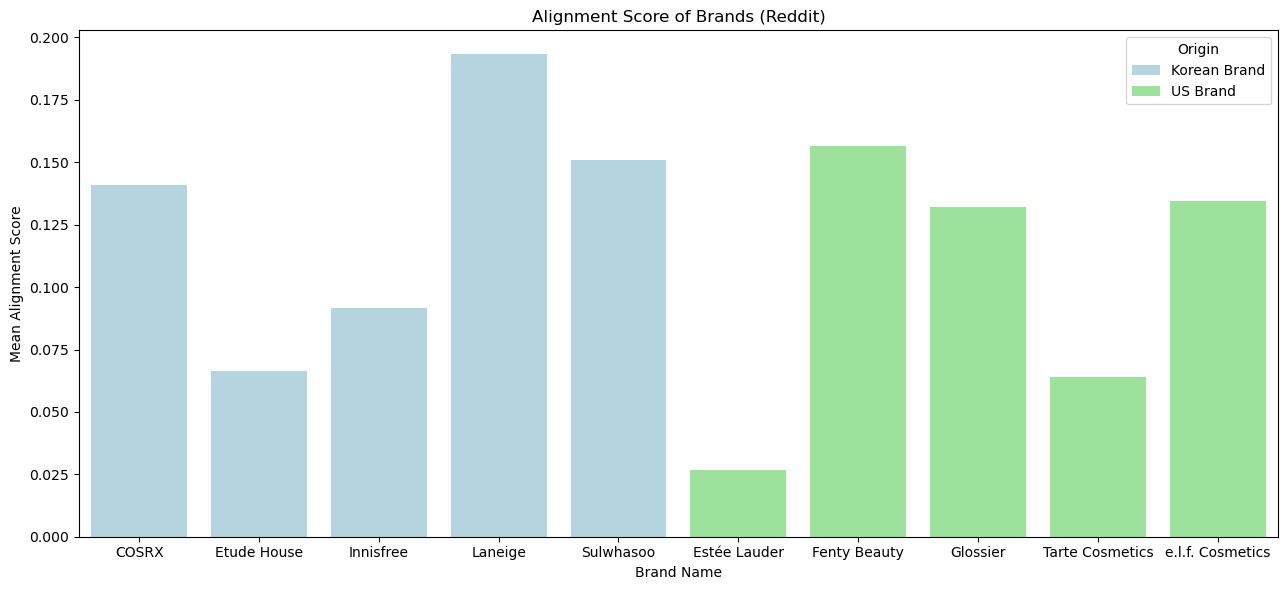

In [68]:
sorted_by_country = insight.sort_values(by=["country", "brand"])

plt.figure(figsize=(13, 6))
sns.barplot(data=sorted_by_country, x="brand", y="mean_alignment", hue="country", palette={"Korean Brand": "lightblue", "US Brand": "lightgreen"})

plt.title("Alignment Score of Brands (Reddit)")
plt.xlabel("Brand Name")
plt.ylabel("Mean Alignment Score")
plt.legend(title="Origin")
plt.tight_layout()
plt.savefig(output_path + "/st_alignment_score.png", dpi=300, bbox_inches="tight")
plt.show()

In [72]:
lemmatizer = WordNetLemmatizer()
stopword_set = set(nltk_stopwords.words('english')).union(custom_stopwords)

def preprocess(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stopword_set and len(word) > 2]

all_brands = []

brand_list = sample_df["brand"].unique().tolist()

for brand in brand_list:
    brand_df = sample_df[sample_df["brand"] == brand]
    texts = brand_df["cleaned_comment"].apply(preprocess).tolist()
    dictionary = Dictionary(texts)  
    corpus = [dictionary.doc2bow(text) for text in texts]  
    lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)  
    vis_data = gensimvis.prepare(lda, corpus, dictionary)
    pyLDAvis.save_html(vis_data, f"../output/lda/lda_{brand.lower().replace(' ', '_')}.html")
    
    # Get the top words as topic lavel 
    topic_terms = lda.show_topics(num_topics=5, num_words=10, formatted=False)
    topic_label_map = {
        topic_id: " ".join([word for word, _ in words])  
        for topic_id, words in topic_terms
    }
    
    labeled_topics = []
    for doc_bow in corpus:
        topic_probs = lda.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic_id = max(topic_probs, key=lambda x: x[1])[0]
        raw_label = topic_label_map[dominant_topic_id]
        
        phrase = ", ".join(raw_label.split())
        sentence = f"People are talking about {brand}'s products with a focus on {phrase}, which may relate to skincare concerns or product features."
        labeled_topics.append(sentence)


    brand_df["topic_label"] = labeled_topics
    brand_df["topic_label"] = labeled_topics
    all_brands.append(brand_df)


all_brands_df = pd.concat(all_brands)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tok

FileNotFoundError: [Errno 2] No such file or directory: '../output/lda/lda_e.l.f._cosmetics.html'

In [31]:
all_brands_df[all_brands_df['normalized_brand'] == 'COSRX']

,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term_x,alignment_score,z_score,topic_label,search_term_y,brand_mission
1682,110wklo,"hi!! ever since starting differin im really drying out. i use the COSRX all in one snail cream + the vanicream lotion for my main moisturizers but i want to add a hydrating, skin barrier repairing serum OR toner into my routine. any recs? i live in canada so pls stuff that’s available in our sephora",COSRX,Sephora,I use tret and I currently use the laneige cream skin refiner but previously used the FAB wild oat toner. I think any sort of milky toner is a nice way to hydrate your skin before using something like differin :),use tret currently use laneige cream skin refiner previously used fab wild oat toner think sort milky toner nice way hydrate skin using something differin,COSRX,COSRX,0.336324,0.379963,"People are talking about COSRX's products with a focus on skin, product, acid, serum, use, snail, day, mucin, bha, cream, which may relate to skincare concerns or product features.",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers."
1683,155ndcq,[REVIEW] COSRX advanced snail 92 all in one “cream”,COSRX,SkincareAddiction,"So here's my two cents. Mucin does appear to have healing benefits, but for skin to be healthy, it needs to retain moisture first and foremost. I found this product far too drying. The Hyaluronic acid sucked my skin dry. However, using this as a... Serum step... And then layering an occlusive moisturizer on top might be the way to go. Perhaps this product will work better underneath something more substantial",two cents mucin appear healing benefits skin healthy needs retain moisture first found product far drying hyaluronic acid sucked skin dry however using serum step layering occlusive moisturizer top might way perhaps product work better underneath something substantial,COSRX,COSRX,0.300806,0.104600,"People are talking about COSRX's products with a focus on skin, cleanser, using, product, routine, acne, gel, sunscreen, look, low, which may relate to skincare concerns or product features.",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers."
1684,1928sit,COSRX Advance Snail 96 Mucin Power Essence vs COSRX Advance Snail 96 All in one cream,COSRX,IndianSkincareAddicts,"Combination skin here- used essence in summers, switched to cream in winters. Cream is perfect in terms of texture in this weather- not too heavy not too light",combination skin used essence summers switched cream winters cream perfect terms texture weather heavy light,COSRX,COSRX,0.384081,0.750201,"People are talking about COSRX's products with a focus on skin, product, acid, serum, use, snail, day, mucin, bha, cream, which may relate to skincare concerns or product features.",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics +

In [19]:
brand_value.head()

,search_term,slogan,brand_mission
0,Estée Lauder,Beauty is an attitude,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."
1,Fenty Beauty,Beauty for all,"FENTY BEAUTY: This is where Rihanna started it all, for all. More than just makeup, it’s a mission with a vision, serving foundation that put every tone on the map. Launching color that created new ways of being and seeing with loaded pigments and freestyle formulas. FENTY SKIN: Great skin makes great makeup. Start your base with Fenty Skin—smart, high-performance skincare with a clear mission: treat, smooth and tighten the look of pores, day and night, under makeup and over time. Never complicated, always clinical. FENTY HAIR: The radically transformative power of hair? Rihanna owns that. But serving looks and switchin’ styles can take its toll. Enter Fenty Hair: a new era of repair. It’s a line that infuses repair into every step for styles that won’t stop. Your hair on Fenty? It’s stronger by the style."
2,e.l.f. Cosmetics,be extra withoutpaying extra,"e.l.f. is for every eye, lip and face. Your originality is our inspiration. From full-on maximalists to fresh-faced\nminimalists, we have a product for everyone—and every look in between. Look good and feel good—all our\nformulas are 100% vegan, no animal testing and made without the nasty bad-for-you stuff. Totally guilt-free."
3,Tarte Cosmetics,"Be green, be smart, be tarte.","About Tarte™\nAt tarte™, we believe in breaking down beauty\nboundaries, shattering stereotypes & being kind.\nWe believe in high-performance AND natural. All tarte products are formulated with a blend of naturally-derived & other ingredients designed to perform.\n• fruit & plant extracts from Mother Nature • clinically-proven ingredients\n• vegan-friendly options • consumer tested results"
4,Glossier,You Look Good,"Before we launched Glossier in 2014, we started as Into The Gloss. A beauty website and community devoted to sharing real information with real people, about really amazing products. It’s where we realized that beauty shouldn’t be built in a boardroom—it should be built by you. This ethos gave birth to our philosophy: Skin First. Makeup Second™. We prioritize skincare because we believe that healthy skin is the best foundation. We believe in thoughtful design and cultivating conversations. It’s at the core of everything we do—the starting point of all our makeup, skincare, bodycare, and fragrance products. At Glossier, beauty is about celebrating freedom of expression, individuality , and having fun. Our Skin First. Makeup Second™ approach ensures that every product supports your skin’s health, allowing your makeup to enhance rather than mask your natural beauty."


In [22]:
print(all_brands_df.columns)

Index(['post_id', 'title', 'brand', 'subreddit_name', 'comment',
       'cleaned_comment', 'normalized_brand', 'search_term', 'alignment_score',
       'z_score', 'topic_label'],
      dtype='object')


In [23]:
all_brands_df = all_brands_df.drop(columns=["brand_mission"], errors="ignore")

all_brands_df = all_brands_df.merge(
    brand_value[["search_term", "brand_mission"]],
    left_on="normalized_brand",
    right_on="search_term",
    how="left"
)
def compute_similarity(row):
    topic_embed = model.encode(row["topic_label"], convert_to_tensor=True)
    mission_embed = model.encode(row["brand_mission"], convert_to_tensor=True)
    return float(util.cos_sim(topic_embed, mission_embed).item())

summary = (
    all_brands_df.groupby(["normalized_brand", "topic_label", "brand_mission"])["alignment_score"]
    .mean()
    .reset_index()
)

summary["similarity_score"] = summary.apply(compute_similarity, axis=1)

# summary.to_csv('../output/topic_user_score.csv')

In [24]:
summary

,normalized_brand,topic_label,brand_mission,alignment_score,similarity_score
0,COSRX,"People are talking about COSRX's products with a focus on one, product, snail, love, skin, cosrx, used, mucin, cream, get, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.288867,0.692145
1,COSRX,"People are talking about COSRX's products with a focus on skin, cleanser, using, product, routine, acne, gel, sunscreen, look, low, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.251845,0.765481
2,COSRX,"People are talking about COSRX's products with a focus on skin, product, acid, serum, use, snail, day, mucin, bha, cream, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.309528,0.704693
3,Estée Lauder,"People are talking about Estée Lauder's products with a focus on product, eye, also, skin, missha, one, cream, dupe, good, serum, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.057117,0.248439
4,Estée Lauder,"People are talking about Estée Lauder's products with a focus on skin, foundation, get, use, also, coverage, used, one, product, time, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.080280,0.272154
5,Estée Lauder,"People are talking about Estée Lauder's products with a focus on use, skin, also, love, one, foundation, make, using, good, would, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.046944,0.347428
6,Etude House,"People are talking about Etude House's products with a focus on skin, mask, dry, one, sunscreen, would, love, cream, toner, feel, which may relate to skincare concerns or product feature

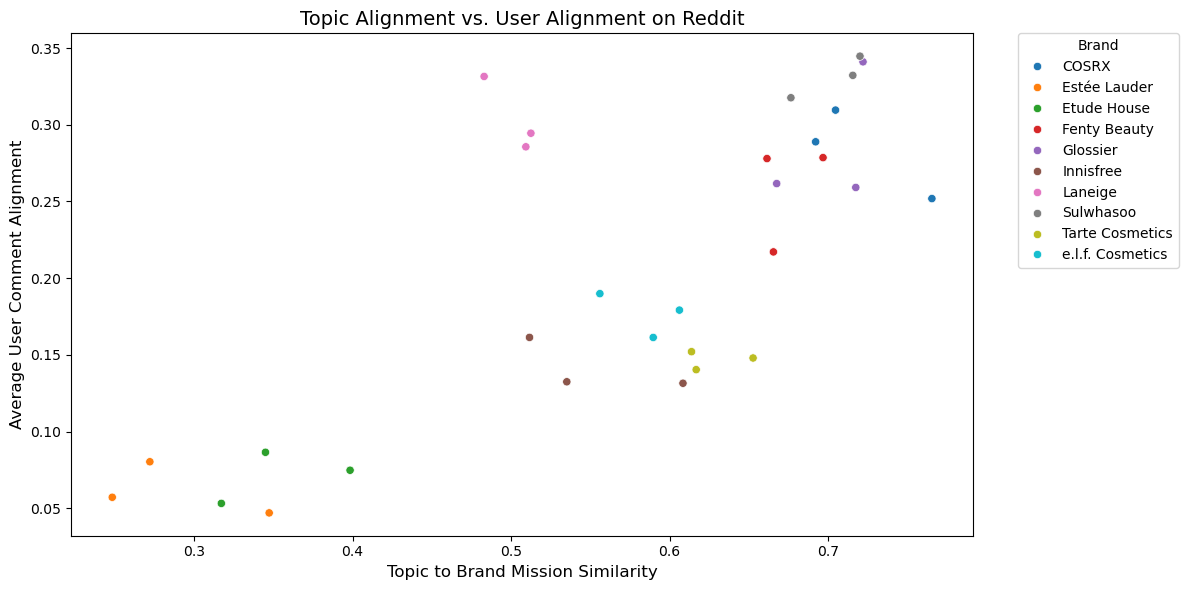

In [27]:
plt.figure(figsize=(12, 6)) 
sns.scatterplot(data=summary, x="similarity_score", y="alignment_score", hue="normalized_brand",)
plt.title("Topic Alignment vs. User Alignment on Reddit", fontsize=14)
plt.xlabel("Topic to Brand Mission Similarity", fontsize=12)
plt.ylabel("Average User Comment Alignment", fontsize=12)
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()

## Main Theme 

Analyzing the main theme of each brand's value and the main theme of the customer's comments  

In [146]:
# Extract top keywords from the brand's value and top keywords from the user's comment 

#function to clean the text 
def cleaning_the_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    return text

# function to extract keywords using FT-IDF 
def get_main_theme(text, top_n=7):
    if not text.strip():
        return None
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    get_scores = tfidf_matrix.toarray().flatten() #convert text into TF-IDF-weighted vector 
    words = vectorizer.get_feature_names_out() # get a list of main theme 
    top_indices = get_scores.argsort()[::-1][:top_n]
    top_keywords = [words[keyword] for keyword in top_indices]
    return ", ".join(top_keywords)

#building a dataframe of main themes for each 
theme_df = []

for brand, group in new_df.groupby("brand"):
    brand_mission = " ".join(group["brand_mission"].map(cleaning_the_text).unique())
    customer_comment = " ".join(group["comment"].map(cleaning_the_text))
    main_theme_brand = get_main_theme(brand_mission)
    main_theme_comment = get_main_theme(customer_comment)
    theme_df.append({
        "brand": brand,
        "brand_mission_main_theme": main_theme_brand,
        "user_comment_main_theme": main_theme_comment})

main_theme_df = pd.DataFrame(theme_df)

main_theme_df

,brand,brand_mission_main_theme,user_comment_main_theme
0,COSRX,"skin, cosmetics, beauty, customers, cosrx, want, founded","skin, like, snail, cosrx, use, using, ve"
1,Estée Lauder,"force, world, women, beauty, believed, caring, championing","skin, use, like, foundation, serum, love, ve"
2,Etude House,"make, pink, princess, like, color, women, fantasy","skin, like, use, just, ve, really, dry"
3,Fenty Beauty,"fenty, hair, makeup, skin, styles, new, repair","like, fenty, skin, love, just, really, use"
4,Glossier,"makeup, beauty, skin, built, products, real, believe","like, glossier, skin, use, cleanser, ve, just"
5,Innisfree,"nature, healthy, beauty, island, innisfree, green, benefits","skin, like, innisfree, use, ve, mask, love"
6,Laneige,"skin, create, visible, ingredients, better, bouncy, caring","lip, laneige, skin, like, mask, lips, use"
7,Sulwhasoo,"skin, sulwhasoo, create, potential, activating, addressing, heritage","skin, sulwhasoo, products, use, like, ve, just"
8,Tarte Cosmetics,"tarte, ingredients, believe, vegan, blend, boundaries, breaking","tarte, like, skin, use, just, love, really"
9,e.l.f. Cosmetics,"good, look, vegan, animal, bad, eye, face","like, skin, elf, products, just, really, use"


In [ ]:
## Attempt with Keybert to run what is common word that led to low alignment and common work to higher alignemtn 



